In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [2]:
genres = list(os.listdir('./Data/genres_original/'))
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [3]:
# Discard filename and length as it gives no information
dataset = pd.read_csv('./Data/features_3_sec.csv').iloc[0:, 2:]
dataset

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


The more data, the better: 9990 instances compared to the 1000 spectrograms. (even if it might seem that 3 sec windows should not model properly the entire genre)

In [4]:
Y = dataset['label']
X = dataset.loc[:, dataset.columns != 'label']

# Normalize X
cols = X.columns
scaler = MinMaxScaler()
scaled_input = scaler.fit_transform(X)
X = pd.DataFrame(scaled_input, columns=cols)

pca = PCA()
principalComponents = pca.fit_transform(X)
principalComponents

array([[-2.42167489e-01, -1.21146568e-01,  7.10578867e-02, ...,
         1.18390705e-03,  9.52651931e-03, -3.28520507e-03],
       [-2.76061511e-01, -2.30291076e-01,  3.89865026e-02, ...,
         9.48647476e-03,  1.70283409e-03, -2.20208787e-03],
       [-1.90024313e-01, -1.19509282e-01,  6.75024037e-02, ...,
        -4.41309670e-04,  4.37235105e-03,  6.74660068e-04],
       ...,
       [-3.90216144e-01,  1.97885066e-01,  2.41838033e-01, ...,
         3.13751676e-02,  6.76318673e-05, -4.70167792e-04],
       [-3.10315416e-01, -3.88161635e-01, -3.05371785e-02, ...,
         2.10508378e-02, -4.78099456e-03, -5.60159539e-04],
       [-3.77906170e-01, -1.06448613e-01,  8.74728597e-02, ...,
         1.38730425e-02, -8.02431982e-03,  6.81585391e-03]])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(principalComponents, Y, random_state=42, stratify=Y, test_size=0.2)
X_train

array([[ 2.76704759e-01,  2.53341184e-01,  1.69727166e-01, ...,
        -7.25610360e-03,  1.72332723e-02,  1.27894556e-03],
       [-7.66803327e-02, -5.65957157e-01, -4.54864618e-02, ...,
         5.77636063e-03,  5.55863473e-04,  4.12496225e-04],
       [ 5.72488937e-01,  4.95094153e-02, -3.47350225e-01, ...,
        -7.41733364e-03, -5.84386485e-03,  5.00470507e-04],
       ...,
       [-3.85289008e-01,  1.41972388e-01,  9.50765902e-02, ...,
        -4.48682840e-05,  5.17358739e-03, -2.50896887e-03],
       [-3.24527679e-01, -1.73609289e-01,  8.29812495e-02, ...,
         8.02360555e-03, -5.04756466e-04,  1.98385419e-03],
       [ 4.31244181e-01, -5.28724927e-02, -3.03363013e-01, ...,
        -7.66138219e-03, -1.36765477e-02, -5.20534759e-03]])

# Dataset with full length audio

In [3]:
# Discard filename and length as it gives no information
dataset = pd.read_csv('./Data/features_30_sec.csv').iloc[0:, 2:]
dataset

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,1.222421e+06,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,1.046621e+06,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,8.042154e+05,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,1.332712e+06,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [4]:
Y = dataset['label']
X = dataset.loc[:, dataset.columns != 'label']

# Normalize X
cols = X.columns
scaler = MinMaxScaler()
scaled_input = scaler.fit_transform(X)
X = pd.DataFrame(scaled_input, columns=cols)

pca = PCA()
principalComponents = pca.fit_transform(X)
principalComponents

array([[-3.94211703e-01, -1.16144926e-01, -9.98054380e-02, ...,
         7.05165761e-03, -6.04733885e-04,  7.37407803e-04],
       [ 5.20187372e-02, -2.70757254e-01,  4.27636674e-01, ...,
         4.60594734e-03,  1.54930532e-02,  1.79221520e-03],
       [-4.79183815e-01, -2.24615950e-01, -1.42946226e-02, ...,
         9.44150225e-03, -1.50864919e-02,  1.21347719e-02],
       ...,
       [-8.45324172e-01, -7.20162381e-03, -1.10543279e-01, ...,
         1.04379605e-02,  1.15854744e-03, -1.64997914e-03],
       [-2.34261649e-01, -3.72665633e-01,  1.37527264e-01, ...,
         1.12835743e-02, -4.18697963e-03,  4.49336878e-04],
       [-3.99060275e-01, -2.76560924e-01,  1.87228798e-01, ...,
         2.12671214e-02,  7.83271351e-03,  2.92997450e-03]])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(principalComponents, Y, random_state=42, stratify=Y, test_size=0.2)
X_train

array([[ 0.30446592,  0.14336231, -0.67873338, ..., -0.02462243,
         0.00657118,  0.00174522],
       [ 0.10616853,  0.49823001, -0.49480197, ..., -0.0118855 ,
         0.02632502,  0.01069283],
       [-0.65013524, -0.01449958, -0.0497728 , ..., -0.00809178,
        -0.0009197 ,  0.00309405],
       ...,
       [ 0.19033734,  0.24557123, -0.21781254, ...,  0.01797345,
        -0.00505196,  0.00403117],
       [ 0.01529569,  0.41267751, -0.3498908 , ..., -0.00083882,
        -0.00194666, -0.00810892],
       [-0.36091572, -0.06200691,  0.08579027, ..., -0.0053079 ,
         0.00337512, -0.00094521]])

### KNN

In [6]:
pipeline = Pipeline([('knn', KNeighborsClassifier())])

param_grid = {
    'knn__n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Best parameters: {'knn__n_neighbors': 5}
Best score: 0.8867613597672512


In [7]:
model.score(X_test, y_test)

0.8903903903903904

In [8]:
y_pred = model.predict(X_test)
y_pred

array(['classical', 'blues', 'disco', 'jazz', 'blues', 'rock', 'country',
       'country', 'hiphop', 'jazz', 'blues', 'blues', 'reggae', 'blues',
       'rock', 'disco', 'country', 'jazz', 'pop', 'country', 'country',
       'blues', 'jazz', 'country', 'blues', 'classical', 'pop', 'pop',
       'classical', 'jazz', 'blues', 'country', 'jazz', 'hiphop',
       'classical', 'metal', 'rock', 'hiphop', 'rock', 'disco', 'rock',
       'rock', 'pop', 'blues', 'jazz', 'disco', 'metal', 'classical',
       'disco', 'pop', 'hiphop', 'metal', 'hiphop', 'jazz', 'reggae',
       'disco', 'classical', 'classical', 'classical', 'disco', 'metal',
       'rock', 'reggae', 'rock', 'disco', 'rock', 'reggae', 'classical',
       'rock', 'pop', 'metal', 'reggae', 'classical', 'reggae', 'reggae',
       'hiphop', 'disco', 'pop', 'pop', 'pop', 'disco', 'pop', 'reggae',
       'pop', 'jazz', 'country', 'rock', 'hiphop', 'disco', 'country',
       'disco', 'reggae', 'metal', 'rock', 'country', 'jazz', 'jazz'

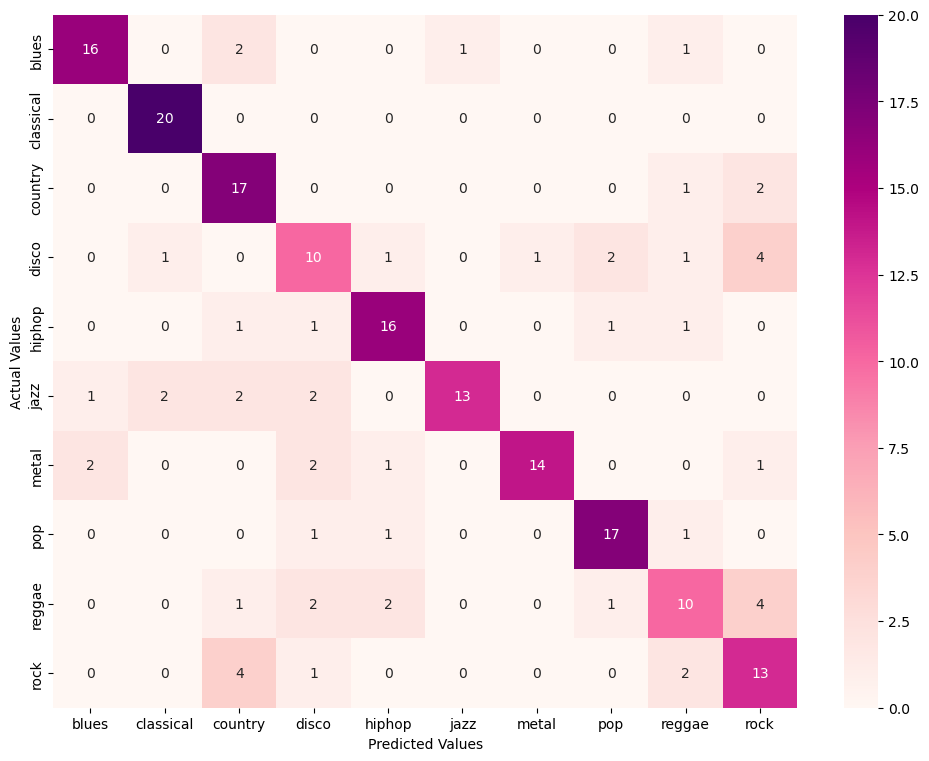

In [9]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/KNN_confusion_matrix.png', bbox_inches='tight')

In [10]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.84      0.80      0.82        20
   classical       0.87      1.00      0.93        20
     country       0.63      0.85      0.72        20
       disco       0.53      0.50      0.51        20
      hiphop       0.76      0.80      0.78        20
        jazz       0.93      0.65      0.76        20
       metal       0.93      0.70      0.80        20
         pop       0.81      0.85      0.83        20
      reggae       0.59      0.50      0.54        20
        rock       0.54      0.65      0.59        20

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.73      0.73       200



### SVM

In [11]:
pipeline = Pipeline([('svm', SVC())])

param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best score: 0.7425


In [12]:
model.score(X_test, y_test)

0.75

In [13]:
y_pred = model.predict(X_test)
y_pred

array(['classical', 'blues', 'disco', 'jazz', 'blues', 'rock', 'pop',
       'country', 'hiphop', 'jazz', 'jazz', 'blues', 'reggae', 'blues',
       'rock', 'disco', 'reggae', 'jazz', 'pop', 'country', 'country',
       'blues', 'blues', 'country', 'blues', 'classical', 'reggae',
       'classical', 'jazz', 'jazz', 'blues', 'country', 'jazz', 'hiphop',
       'jazz', 'metal', 'rock', 'hiphop', 'country', 'disco', 'rock',
       'rock', 'pop', 'blues', 'jazz', 'jazz', 'metal', 'classical',
       'hiphop', 'hiphop', 'hiphop', 'metal', 'hiphop', 'jazz', 'reggae',
       'disco', 'classical', 'classical', 'classical', 'pop', 'blues',
       'reggae', 'reggae', 'rock', 'disco', 'rock', 'reggae', 'classical',
       'rock', 'pop', 'metal', 'reggae', 'classical', 'reggae', 'reggae',
       'hiphop', 'disco', 'pop', 'classical', 'pop', 'hiphop', 'pop',
       'reggae', 'hiphop', 'jazz', 'rock', 'reggae', 'hiphop', 'pop',
       'jazz', 'rock', 'reggae', 'metal', 'disco', 'country', 'jazz',
  

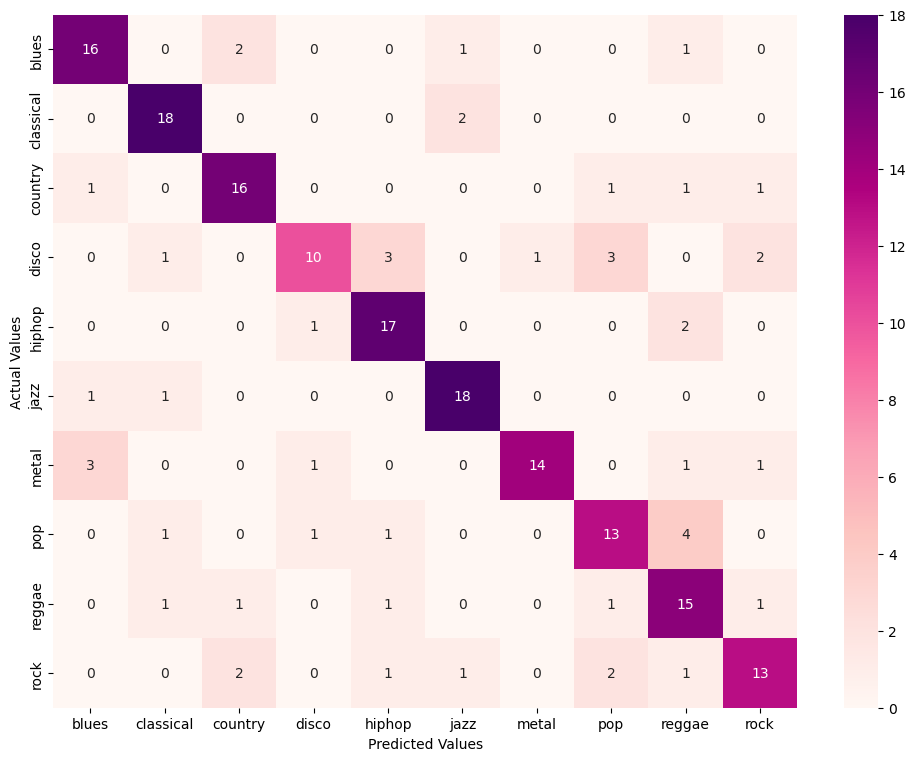

In [14]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/SVM_confusion_matrix.png', bbox_inches='tight')

In [15]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.76      0.80      0.78        20
   classical       0.82      0.90      0.86        20
     country       0.76      0.80      0.78        20
       disco       0.77      0.50      0.61        20
      hiphop       0.74      0.85      0.79        20
        jazz       0.82      0.90      0.86        20
       metal       0.93      0.70      0.80        20
         pop       0.65      0.65      0.65        20
      reggae       0.60      0.75      0.67        20
        rock       0.72      0.65      0.68        20

    accuracy                           0.75       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.75      0.75       200



# Random Forest

In [16]:
pipeline = Pipeline([('rf', RandomForestClassifier())])

param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best score: 0.6837500000000001


In [17]:
model.score(X_test, y_test)

0.69

In [18]:
y_pred = model.predict(X_test)
y_pred

array(['classical', 'reggae', 'hiphop', 'jazz', 'blues', 'rock',
       'country', 'country', 'hiphop', 'jazz', 'blues', 'reggae',
       'reggae', 'blues', 'rock', 'hiphop', 'reggae', 'jazz', 'disco',
       'pop', 'country', 'blues', 'blues', 'country', 'blues',
       'classical', 'pop', 'hiphop', 'jazz', 'jazz', 'blues', 'disco',
       'jazz', 'hiphop', 'classical', 'metal', 'metal', 'hiphop',
       'country', 'disco', 'hiphop', 'rock', 'pop', 'blues', 'jazz',
       'jazz', 'metal', 'classical', 'disco', 'hiphop', 'hiphop', 'metal',
       'hiphop', 'jazz', 'reggae', 'jazz', 'classical', 'classical',
       'classical', 'country', 'metal', 'hiphop', 'reggae', 'rock',
       'disco', 'reggae', 'reggae', 'classical', 'rock', 'pop', 'metal',
       'reggae', 'classical', 'reggae', 'reggae', 'jazz', 'disco', 'pop',
       'pop', 'pop', 'disco', 'pop', 'hiphop', 'pop', 'jazz', 'rock',
       'reggae', 'hiphop', 'disco', 'country', 'metal', 'reggae', 'metal',
       'disco', 'country'

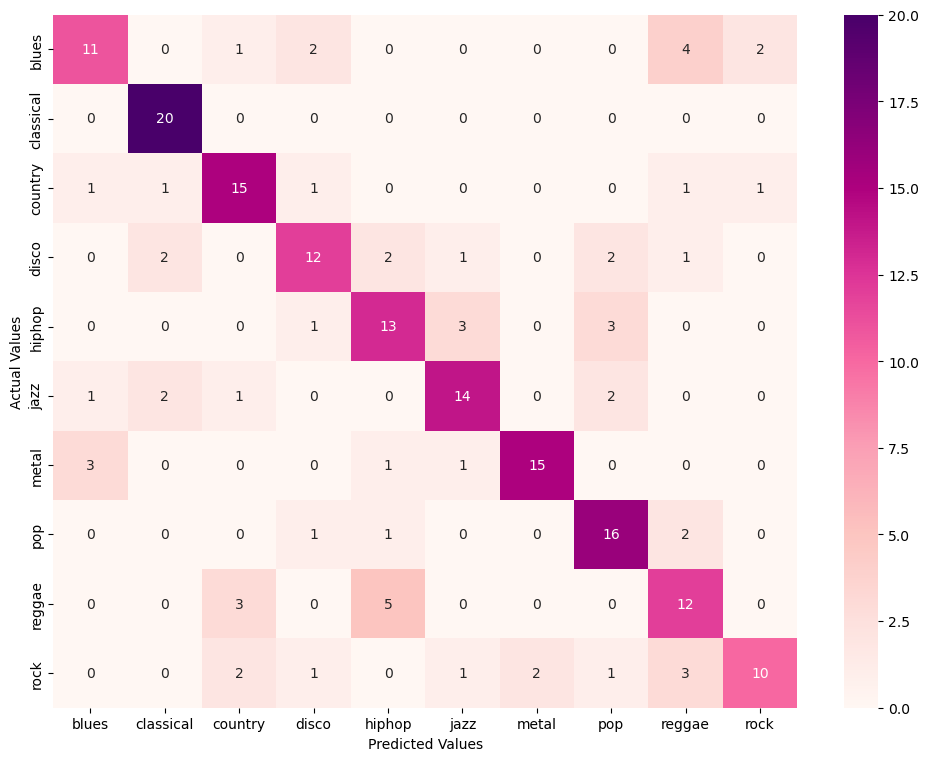

In [19]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/RandomForest_confusion_matrix.png', bbox_inches='tight')

In [20]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.69      0.55      0.61        20
   classical       0.80      1.00      0.89        20
     country       0.68      0.75      0.71        20
       disco       0.67      0.60      0.63        20
      hiphop       0.59      0.65      0.62        20
        jazz       0.70      0.70      0.70        20
       metal       0.88      0.75      0.81        20
         pop       0.67      0.80      0.73        20
      reggae       0.52      0.60      0.56        20
        rock       0.77      0.50      0.61        20

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.70      0.69      0.69       200

